# Dependencies

In [ ]:
pip install opencv-python

In [108]:
from pathlib import Path
from PIL import Image
import pillow_heif

# Register HEIF/HEIC support for Pillow
pillow_heif.register_heif_opener()

# Define the folder containing your images
input_folder = Path("./object_images-heic")  # current directory
output_folder = Path("./object-images")
output_folder.mkdir(exist_ok=True)

# Loop through all HEIC/HEIF files (case-insensitive)
heic_files = list(input_folder.glob("*.HEIC")) + list(input_folder.glob("*.heic")) + list(input_folder.glob("*.heif"))
if not heic_files:
    print("No HEIC/HEIF files found in this folder.")
else:
    for img_path in heic_files:
        try:
            img = Image.open(img_path)
            rgb_img = img.convert("RGB")
            out_path = output_folder / (img_path.stem + ".jpg")
            rgb_img.save(out_path, "JPEG", quality=95)
            print(f"✅ Converted {img_path.name} → {out_path.name}")
        except Exception as e:
            print(f"⚠️ Failed to convert {img_path.name}: {e}")

    print("\n🎉 Done! All JPGs saved in:", output_folder.resolve())

✅ Converted IMG_6280.HEIC → IMG_6280.jpg
✅ Converted IMG_6279.HEIC → IMG_6279.jpg
✅ Converted IMG_6263.HEIC → IMG_6263.jpg
✅ Converted IMG_6275.HEIC → IMG_6275.jpg
✅ Converted IMG_6274.HEIC → IMG_6274.jpg
✅ Converted IMG_6262.HEIC → IMG_6262.jpg
✅ Converted IMG_6278.HEIC → IMG_6278.jpg
✅ Converted IMG_6281.HEIC → IMG_6281.jpg
✅ Converted IMG_6265.HEIC → IMG_6265.jpg
✅ Converted IMG_6273.HEIC → IMG_6273.jpg
✅ Converted IMG_6269.HEIC → IMG_6269.jpg
✅ Converted IMG_6268.HEIC → IMG_6268.jpg
✅ Converted IMG_6272.HEIC → IMG_6272.jpg
✅ Converted IMG_6264.HEIC → IMG_6264.jpg
✅ Converted IMG_6271.HEIC → IMG_6271.jpg
✅ Converted IMG_6267.HEIC → IMG_6267.jpg
✅ Converted IMG_6284.HEIC → IMG_6284.jpg
✅ Converted IMG_6266.HEIC → IMG_6266.jpg
✅ Converted IMG_6270.HEIC → IMG_6270.jpg
✅ Converted IMG_6282.HEIC → IMG_6282.jpg
✅ Converted IMG_6277.HEIC → IMG_6277.jpg
✅ Converted IMG_6276.HEIC → IMG_6276.jpg
✅ Converted IMG_6283.HEIC → IMG_6283.jpg

🎉 Done! All JPGs saved in: /Users/zanedanton/github.io-m

## Part 0.1: Calibrating Your Camera

In [ ]:
import cv2
import numpy as np
import os

# Create ArUco dictionary and detector parameters (4x4 tags)
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()

DOWNSAMPLE_FACTOR = 6

def import_images(path):
    images = []
    for filename in os.listdir(path):
        if filename.lower().endswith('.jpg'):
            img_path = os.path.join(path, filename)
            image = cv2.imread(img_path)

            if DOWNSAMPLE_FACTOR > 1.0:
                h, w = image.shape[:2]
                h_new = int(h / DOWNSAMPLE_FACTOR)
                w_new = int(w / DOWNSAMPLE_FACTOR)
                image = cv2.resize(image, (w_new, h_new), interpolation=cv2.INTER_AREA)
            
                images.append(image)
            
            else:
                images.append(image)
    return images

def get_points(images):
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    aruco_params = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)

    tag_size = 0.06
    h_pitch = 0.09
    v_pitch = 0.07567

    board_layout = {
        # like
        # 0 1
        # 2 3
        # 4 5

        0: np.array([
            [0, 0, 0],
            [tag_size, 0, 0],
            [tag_size, tag_size, 0],
            [0, tag_size, 0]
        ], dtype=np.float32),
        
        1: np.array([
            [h_pitch, 0, 0],
            [h_pitch + tag_size, 0, 0],
            [h_pitch + tag_size, tag_size, 0],
            [h_pitch, tag_size, 0]
        ], dtype=np.float32),

        2: np.array([
            [0, v_pitch, 0],
            [tag_size, v_pitch, 0],
            [tag_size, v_pitch + tag_size, 0],
            [0, v_pitch + tag_size, 0]
        ], dtype=np.float32),

        3: np.array([
            [h_pitch, v_pitch, 0],
            [h_pitch + tag_size, v_pitch, 0],
            [h_pitch + tag_size, v_pitch + tag_size, 0],
            [h_pitch, v_pitch + tag_size, 0]
        ], dtype=np.float32),

        4: np.array([
            [0, 2 * v_pitch, 0],
            [tag_size, 2 * v_pitch, 0],
            [tag_size, 2 * v_pitch + tag_size, 0],
            [0, 2 * v_pitch + tag_size, 0]
        ], dtype=np.float32),

        5: np.array([
            [h_pitch, 2 * v_pitch, 0],
            [h_pitch + tag_size, 2 * v_pitch, 0],
            [h_pitch + tag_size, 2 * v_pitch + tag_size, 0],
            [h_pitch, 2 * v_pitch + tag_size, 0]
        ], dtype=np.float32)
    }

    object_points = [] 
    image_points = []  
    image_size = None

    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image_size is None:
            image_size = gray.shape[::-1] 

        corners, ids, _ = detector.detectMarkers(gray)

        if ids is not None:
            aruco_points= np.empty((0, 3), dtype=np.float32)
            img_points = np.empty((0, 2), dtype=np.float32)

            for i in range(len(ids)):
                current_id = ids[i][0]
                
                # get the points for current id
                if current_id in board_layout:
                    correct_aruco_points = board_layout[current_id]
                    correct_img_points = corners[i].reshape(4, 2)

                    aruco_points = np.vstack((aruco_points, correct_aruco_points)) # array of aruco points in paper coordinates
                    img_points = np.vstack((img_points, correct_img_points)) # array of aruco points in image coordinates
                
            if img_points.shape[0] > 0:
                object_points.append(aruco_points) # num images x num points x 3
                image_points.append(img_points) # num images x num points x 2
                cv2.aruco.drawDetectedMarkers(image, corners, ids)
        else:
            pass 

    return object_points, image_points, image_size

images = import_images("./aruco-images")
object_points, image_points, image_size = get_points(images)

## Calibrate

In [110]:
if image_size is not None and object_points:
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
            object_points, 
            image_points, 
            image_size,  # w, h
            None, 
            None
        )

    if ret:
        print("\nCamera Matrix (K):")
        print(camera_matrix)

        print(f"Reprojection Error: {ret}")
        
        print("\nDistortion Coefficients:")
        print(dist_coeffs)
        
        os.makedirs('./personal_calibrate_results', exist_ok=True)
        np.savez('./personal_calibrate_results/camera_calibration.npz', camera_matrix=camera_matrix, dist_coeffs=dist_coeffs)
    else:
        print("\nFailed")
else:
    print("\n")


Camera Matrix (K):
[[507.12616495   0.         249.54576899]
 [  0.         508.34894686 340.4665472 ]
 [  0.           0.           1.        ]]
Reprojection Error: 0.7334378624462136

Distortion Coefficients:
[[ 0.20729744 -0.89728977  0.00322427 -0.00236937  0.98439705]]


## Part 0.2: Capturing a 3D Object Scan

Placed in ./object_images

## Part 0.3: Estimating Camera Pose


In [111]:
import cv2
import numpy as np
import os
import glob
import time

CALIBRATION_DIR = './aruco-images'
IMAGES_DIR = './object-images' 
TAG_SIZE = 0.06
FRUSTUM_SCALE = 0.02
CALIBRATION_FILE = './personal_calibrate_results/camera_calibration.npz'

# Load calibration data
calibration_data = np.load(CALIBRATION_FILE)
camera_matrix = calibration_data['camera_matrix']
dist_coeffs = calibration_data['dist_coeffs']

# Import images
object_scan_images = import_images(IMAGES_DIR)

single_tag_object_points = np.array([
    [0.0, 0.0, 0.0],
    [TAG_SIZE, 0.0, 0.0],
    [TAG_SIZE, TAG_SIZE, 0.0],
    [0.0, TAG_SIZE, 0.0]
], dtype=np.float32)

valid_c2w_matrices = []
valid_images = []

H, W = 0, 0

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)

for img in object_scan_images:
    if H == 0:
        H, W = img.shape[:2]
    
    # Detect markers
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = detector.detectMarkers(gray)

    if ids is not None:
        target_id = 0
        found = False
        target_corners = None
        
        for i, tag_id in enumerate(ids):
            if tag_id[0] == target_id:
                target_corners = corners[i].reshape(4, 2)
                found = True
                break

        if found:
            success, rvec, tvec = cv2.solvePnP(
                objectPoints=single_tag_object_points, 
                imagePoints=target_corners,
                cameraMatrix=camera_matrix, 
                distCoeffs=dist_coeffs
            )
            
            if success:
                R, _ = cv2.Rodrigues(rvec)
                
                w2c_matrix = np.eye(4)
                w2c_matrix[:3, :3] = R
                w2c_matrix[:3, 3] = tvec.ravel()
                
                # invert per spec to get w2c
                c2w_matrix = np.linalg.inv(w2c_matrix)

                # because all the images are upside down in viser per ed
                flip_matrix = np.array([
                    [1, 0, 0, 0],
                    [0, 0, 1, 0],
                    [0, -1, 0, 0],
                    [0, 0, 0, 1]
                ], dtype=np.float32)
                
                # c2w_matrix = flip_matrix @ c2w_matrix
                
                valid_c2w_matrices.append(c2w_matrix)
                valid_images.append(img)
            
        else:
            pass 
    else:
        pass

print(f"Found {len(valid_images)} images containing Tag ID 0.")

Found 83 images containing Tag ID 0.


In [116]:
import viser
import numpy as np

server = viser.ViserServer(share=True)

focal = camera_matrix[0, 0]
fov_y = 2 * np.arctan2(H / 2, focal)
aspect_ratio = W / H

for i in range(len(valid_c2w_matrices)):
    c2w = valid_c2w_matrices[i]
    img = valid_images[i]
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    server.scene.add_camera_frustum(
        f"/cameras/{i}",
        fov=fov_y,
        aspect=aspect_ratio,
        scale=FRUSTUM_SCALE,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=img_rgb
    )

print("Visualization running. Open the URL in your browser.")
while True:
    time.sleep(0.1)

╭────── viser (listening *:8093) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8093   │
│   Websocket │ ws://localhost:8093     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://control-point.share.viser.studio

Visualization running. Open the URL in your browser.


(viser) Connection opened (0, 1 total), 338 persistent messages

(viser) Connection closed (0, 0 total)

(viser) Connection opened (1, 1 total), 338 persistent messages

(viser) Connection closed (1, 0 total)

(viser) Connection opened (2, 1 total), 338 persistent messages

(viser) Disconnected from share URL

KeyboardInterrupt: 

(viser) Connection closed (2, 0 total)

## Part 0.4: Undistorting images and creating a dataset

In [115]:
calib_data = np.load(CALIBRATION_FILE)
camera_matrix = calib_data['camera_matrix']
dist_coeffs = calib_data['dist_coeffs']

H, W = valid_images[0].shape[:2]

# camera matrix and roi
# remove black per spec
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
    camera_matrix, dist_coeffs, (W, H), alpha=0
)

x, y, w_roi, h_roi = roi

new_camera_matrix[0, 2] -= x  # cx
new_camera_matrix[1, 2] -= y  # cy

undistorted_images = []

for img in valid_images:
    undistorted_img = cv2.undistort(
        img, 
        camera_matrix, 
        dist_coeffs, 
        None,
        new_camera_matrix
    )
    
    cropped_img = undistorted_img[y:y+h_roi, x:x+w_roi]
    
    undistorted_images.append(cropped_img)

images = np.stack(undistorted_images, axis=0).astype(np.uint8)
c2ws = np.stack(valid_c2w_matrices, axis=0).astype(np.float32)

focal = new_camera_matrix[0, 0]

# separate into training and val/test sets
indices = np.arange(len(images))
val_test_mask = (indices % 8 == 0)
train_mask = ~val_test_mask

images_train = images[train_mask]
c2ws_train = c2ws[train_mask]

images_val = images[val_test_mask]
c2ws_val = c2ws[val_test_mask]

c2ws_test = c2ws_val

cx_final = new_camera_matrix[0, 2]
cy_final = new_camera_matrix[1, 2]

np.savez(
    'personal_data.npz',
    images_train=images_train,    # (N_train, H, W, 3)
    c2ws_train=c2ws_train,        # (N_train, 4, 4)
    images_val=images_val,        # (N_val, H, W, 3)
    c2ws_val=c2ws_val,            # (N_val, 4, 4)
    c2ws_test=c2ws_test,          # (N_test, 4, 4)
    focal=focal,                   # float
    cx=cx_final,
    cy=cy_final
)

# Part 1

## Ran in Colab

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import os
from collections import OrderedDict

device = torch.device("cuda")

class PositionalEncoder(nn.Module):
    def __init__(self, L=10):
        super(PositionalEncoder, self).__init__()
        self.L = L
        self_freq_bands = (2.0**torch.arange(L)) * torch.pi # vals inside sin/cos
        self.register_buffer('freq_bands', self_freq_bands)

    def forward(self, x):
        encoded_list = [x]
        for freq in self.freq_bands:
            scaled_x = x * freq
            encoded_list.append(torch.sin(scaled_x))
            encoded_list.append(torch.cos(scaled_x))
        return torch.cat(encoded_list, dim=-1)

def create_image_mlp(L=10, width=256):
    input_dim = 2 + 2*2*L  # 42

    # per blog
    layers = OrderedDict([
        ('encoder', PositionalEncoder(L=L)),
        ('dense1', nn.Linear(input_dim, width)),
        ('act1', nn.ReLU()),
        ('dense2', nn.Linear(width, width)),
        ('act2', nn.ReLU()),
        ('dense3', nn.Linear(width, width)),
        ('act3', nn.ReLU()),
        ('dense4', nn.Linear(width, width)),
        ('act4', nn.ReLU()),
        ('output', nn.Linear(width, 3)),
        ('out_act', nn.Sigmoid())
    ])

    model = nn.Sequential(layers)
    return model

def load_image(image_path, max_dim=400):
    img = Image.open(image_path).convert('RGB')
    img.thumbnail((max_dim, max_dim))
    H, W = img.height, img.width

    y, x = torch.meshgrid(
        torch.linspace(0, 1, H),
        torch.linspace(0, 1, W),
        indexing='ij'
    )
    coords = torch.stack((x, y), dim=-1)
    pixels = torch.tensor(np.array(img) / 255.0, dtype=torch.float32)

    coords_flat = coords.reshape(-1, 2)
    pixels_flat = pixels.reshape(-1, 3)

    return coords_flat, pixels_flat, H, W

def get_batch(coords, pixels, batch_size):
    indices = torch.randperm(coords.shape[0])[:batch_size]
    batch_coords = coords[indices]
    batch_pixels = pixels[indices]
    return batch_coords.to(device), batch_pixels.to(device)

def psnr(mse):
    return -10.0 * torch.log10(mse)

L_freq = 10
mlp_width = 128
LEARNING_RATE = 1e-2
ITERATIONS = 2000
BATCH_SIZE = 10000

IMAGE_PATH = "fox.jpg"
coords_flat, pixels_flat, H, W = load_image(IMAGE_PATH, max_dim=400)

model = create_image_mlp(L=L_freq, width=mlp_width).to(device)

print(model)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

psnr_vals = []
iteration_history = []
image_progression = []

for i in range(ITERATIONS + 1):
    batch_coords, batch_pixels = get_batch(coords_flat, pixels_flat, BATCH_SIZE)

    predicted_pixels = model(batch_coords)
    loss = criterion(predicted_pixels, batch_pixels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        current_psnr = psnr(loss)
        psnr_vals.append(current_psnr.item())
        iteration_history.append(i)

        print(f"Iter: {i:4d} | Loss: {loss.item():.6f} | PSNR: {current_psnr.item():.2f} dB")

        with torch.no_grad():
            pred_chunks = []
            for j in range(0, coords_flat.shape[0], BATCH_SIZE):
                batch_coords_chunk = coords_flat[j : j + BATCH_SIZE].to(device)
                pred_chunks.append(model(batch_coords_chunk).cpu())

            full_pred = torch.cat(pred_chunks, dim=0)
            img_pred = full_pred.reshape(H, W, 3).numpy()
            image_progression.append(img_pred)

In [ ]:
# PSNR
plt.figure(figsize=(10, 4))
plt.plot(iteration_history, psnr_vals)
plt.title(f"Training PSNR (L={L_freq}, Width={mlp_width})")
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.show()

# iterations
iterations = [0, 50, 300, 600]
fig, axes = plt.subplots(1, len(iterations), figsize=(20, 5))

for i, iter_num in enumerate(iterations):
    img_idx = iteration_history.index(iter_num)

    img = image_progression[img_idx]

    axes[i].imshow(np.clip(img, 0, 1))
    axes[i].set_title(f"Iter: {iter_num}")
    axes[i].axis('off')

plt.suptitle("Training Progression")
plt.show()


# comparison
gt_image = pixels_flat.reshape(H, W, 3).numpy()
final_image = image_progression[-1]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(gt_image)
axes[0].set_title("Ground Truth")
axes[0].axis('off')

axes[1].imshow(np.clip(final_image, 0, 1))
axes[1].set_title(f"Model Output (Iter: {iteration_history[-1]})")
axes[1].axis('off')

plt.show()

# Part 2

## Data parsing code from spec

In [31]:
import numpy as np
import cv2
import os
import imageio

data = np.load(f"part2/lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # This is a 0D numpy array

H, W = images_train.shape[1:3] # 200, 200

cx = W / 2.0
cy = H / 2.0

K = np.array([
    [focal, 0, cx],
    [0, focal, cy],
    [0, 0, 1]
], dtype=np.float32)

print(f"Data loaded: H={H}, W={W}, focal={focal}")
print(f"K matrix:\n{K}")

Data loaded: H=200, W=200, focal=277.77775779844205
K matrix:
[[277.77777   0.      100.     ]
 [  0.      277.77777 100.     ]
 [  0.        0.        1.     ]]


## Part 2.1: Create Rays from Cameras

In [32]:
import numpy as np
import torch

device = torch.device("cpu")

def transform(c2w, x_c):
    R = c2w[:3, :3]
    t = c2w[:3, 3]
    x_w = x_c @ R.T + t
    return x_w

def pixel_to_camera(K, uv, s=1.0):
    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]
    
    u = uv[:, 0]
    v = uv[:, 1]
    
    # invert
    x_c = (u - cx) * s / fx
    y_c = (v - cy) * s / fy
    z_c = np.full_like(x_c, s)
    
    # (N, 3) points
    return np.stack([x_c, y_c, z_c], axis=-1)

def pixel_to_ray(K, c2w, uv):
    N = uv.shape[0]
    
    o = c2w[:3, 3]
    ray_o = np.broadcast_to(o, (N, 3))
    x_c = pixel_to_camera(K, uv, s=1.0) # (N, 3)

    R = c2w[:3, :3] # (3, 3)
    
    vec_w = x_c @ R.T # (N, 3)
    
    norm = np.linalg.norm(vec_w, axis=-1, keepdims=True)
    ray_d = vec_w / norm
    
    return ray_o, ray_d

## Part 2.2: Sampling

In [33]:
class RaysData:
    def __init__(self, images, K, c2ws):
        self.images = images
        self.K = K
        self.c2ws = c2ws
        self.num_images, self.H, self.W, _ = self.images.shape
        self.compute_rays()

    def compute_rays(self):
        # convert image to pixel grid
        u_coords, v_coords = np.meshgrid(
            np.arange(self.W), 
            np.arange(self.H), 
            indexing='xy'
        )

        #(H*W, 2)
        uv_grid = np.stack([u_coords.flatten(), v_coords.flatten()], axis=-1)
        uv_pixels = uv_grid + 0.5 # add .5 per spec to set at pixel center

        all_rays_o = []
        all_rays_d = []
        all_pixels = []

        # sample
        for i in range(self.num_images):
            image = self.images[i]
            c2w = self.c2ws[i]

            rays_o, rays_d = pixel_to_ray(self.K, c2w, uv_pixels)
            
            pixels = image.reshape(-1, 3) # (H*W, 3)

            all_rays_o.append(rays_o)
            all_rays_d.append(rays_d)
            all_pixels.append(pixels)
            
        self.rays_o = np.concatenate(all_rays_o)
        self.rays_d = np.concatenate(all_rays_d)
        self.pixels = np.concatenate(all_pixels)
        
        self.uvs = np.tile(uv_pixels, (self.num_images, 1))
        
        self.num_total_rays = self.rays_o.shape[0]


    def sample_rays(self, batch_size):
        indices = np.random.randint(0, self.num_total_rays, size=batch_size)
        
        # get data at the indices generated from our batch size
        batch_rays_o = self.rays_o[indices]
        batch_rays_d = self.rays_d[indices]
        batch_pixels = self.pixels[indices]
        
        return batch_rays_o, batch_rays_d, batch_pixels

In [34]:
def sample_along_rays(rays_o, rays_d, near=2.0, far=6.0, n_samples=64, perturb=True):
    B = rays_o.shape[0]

    t = np.linspace(near, far, n_samples,) # per spec
    
    if perturb:
        t_width = (far - near) / n_samples
        noise = np.random.rand(B, n_samples) * t_width # per sepc
        t = t[np.newaxis, :] + noise
    else:
        t = np.broadcast_to(t, (B, n_samples))

    # Calculate 3D points
    pts = rays_o[:, np.newaxis, :] + rays_d[:, np.newaxis, :] * t[..., np.newaxis]

    return pts, t

## Part 2.3: Putting the Dataloading All Together

In [ ]:
import viser, time  # pip install viser

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(100) # Should expect (B, 3)
points, _ = sample_along_rays(rays_o, rays_d, perturb=True)
H, W = images_train.shape[1:3]
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run

In [ ]:
# Visualize Cameras, Rays and Samples
import viser, time
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)

# This will check that your uvs aren't flipped
uvs_start = 0
uvs_end = 40_000
sample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image
# uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]
assert np.allclose(images_train[0, sample_uvs[:,1], sample_uvs[:,0]], dataset.pixels[uvs_start:uvs_end])

# # Uncoment this to display random rays from the first image
# indices = np.random.randint(low=0, high=40_000, size=100)

# # Uncomment this to display random rays from the top left corner of the image
indices_x = np.random.randint(low=100, high=200, size=100)
indices_y = np.random.randint(low=0, high=100, size=100)
indices = indices_x + (indices_y * 200)

data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
points, _ = sample_along_rays(data["rays_o"], data["rays_d"], perturb=True)
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )
for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
  positions = np.stack((o, o + d * 6.0))
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.03,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run

## Part 2.4: Neural Radiance Field
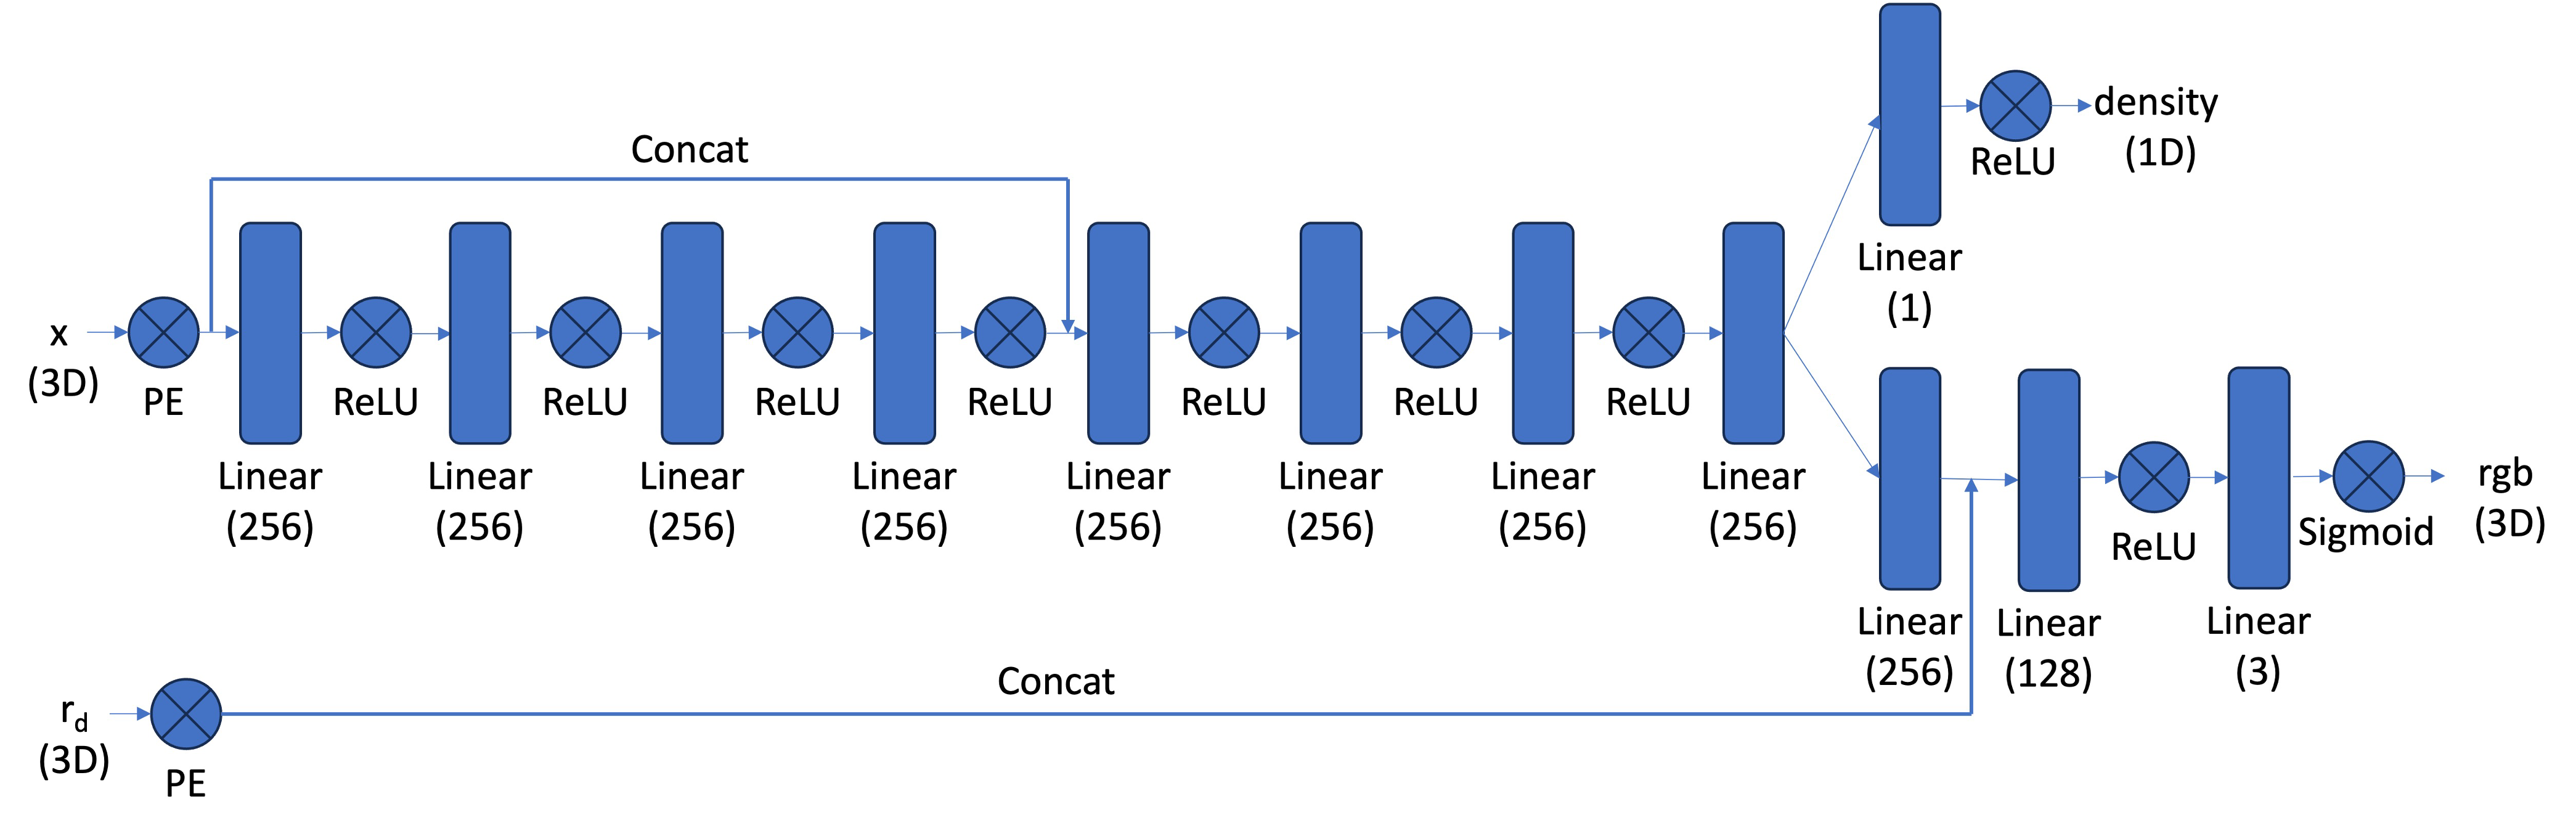

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoder(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L
        self.freqs = 2.0 ** torch.arange(L).float() * torch.pi # 2^0, up to 2^L-1

    def forward(self, x):
        self.freqs = self.freqs.to(x.device)
        encoded_list = [x]
        for freq in self.freqs:
            encoded_list.append(torch.sin(x * freq))
            encoded_list.append(torch.cos(x * freq))
        return torch.cat(encoded_list, dim=-1)

class NeRF(nn.Module):
    def __init__(self, L_pos=10, L_dir=4, hidden_dim=256):
        super().__init__()
        
        self.pe_x = PositionalEncoder(L_pos)
        self.pe_rd = PositionalEncoder(L_dir)
        
        self.input_dim_x = 3+2*3*L_pos
        self.input_dim_rd = 3+2*3*L_dir

        # 4 layers before we concat
        self.linear1 = nn.Linear(self.input_dim_x, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, hidden_dim)
        
        # 4 after we concat
        self.linear5 = nn.Linear(hidden_dim + self.input_dim_x, hidden_dim)
        self.linear6 = nn.Linear(hidden_dim, hidden_dim)
        self.linear7 = nn.Linear(hidden_dim, hidden_dim)
        self.linear8 = nn.Linear(hidden_dim, hidden_dim)
        
        # for sigma 
        self.density_linear = nn.Linear(hidden_dim, 1)
        self.density_relu = nn.ReLU() 
        
        # for color
        self.color_linear1 = nn.Linear(hidden_dim + self.input_dim_rd, hidden_dim // 2) # concat the rd there
        self.color_linear2 = nn.Linear(hidden_dim // 2, 3)
        self.color_sigmoid = nn.Sigmoid()

    def forward(self, x, rd):
        flat_x = x.reshape(-1, 3)
        flat_rd = rd.reshape(-1, 3)

        encoded_x = self.pe_x(flat_x)
        encoded_rd = self.pe_rd(flat_rd)
        
        # first 4 layers
        h = F.relu(self.linear1(encoded_x))
        h = F.relu(self.linear2(h))
        h = F.relu(self.linear3(h))
        h = F.relu(self.linear4(h))
        
        # concat
        h_skip_concat = torch.cat([h, encoded_x], dim=-1)
        
        # 4 layers after concat
        h = F.relu(self.linear5(h_skip_concat))
        h = F.relu(self.linear6(h))
        h = F.relu(self.linear7(h))
        final_features = F.relu(self.linear8(h))
        
        # density
        raw_density = self.density_linear(final_features)
        density = self.density_relu(raw_density)
        
        # color
        color_input = torch.cat([final_features, encoded_rd], dim=-1)
        
        h_color = F.relu(self.color_linear1(color_input))
        raw_rgb = self.color_linear2(h_color)
        rgb = self.color_sigmoid(raw_rgb)
        
        rgb = rgb.view(x.shape[0], x.shape[1], 3)
        density = density.view(x.shape[0], x.shape[1], 1)
        
        return rgb, density

![Screenshot 2025-11-12 at 7.11.47 PM.png](<attachment:Screenshot 2025-11-12 at 7.11.47 PM.png>)
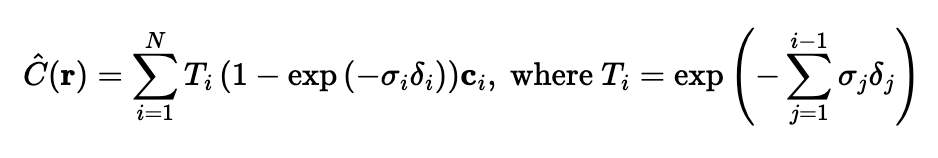

In [36]:
import torch

def volrend(sigmas, rgbs, step_size):
    # alpha_i = 1 - exp(-sigma_i*delta_i)
    alpha = 1.0 - torch.exp(-sigmas * step_size)
    
    # T_i = prod(1 - alpha_j) for j < i
    ones = torch.ones_like(alpha[:, :1]) 
    
    # (1 - alpha)
    one_minus_alpha = 1.0 - alpha + 1e-10 
    
    all_alphas = torch.cat([ones, one_minus_alpha[:, :-1, :]], dim=1)
    T = torch.cumprod(all_alphas, dim=1)
    
    weights = T * alpha
    weighted_colors = weights * rgbs
    
    colors = torch.sum(weighted_colors, dim=1)
    
    return colors

### Assertion Check

In [37]:
import torch
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1))
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)

correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
  ])
assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

data = np.load("lego_200x200.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]
c2ws_test = data["c2ws_test"]
focal = float(data["focal"])
H, W = images_train.shape[1:3]
cx = W / 2.0
cy = H / 2.0
K = np.array([[focal, 0, cx], [0, focal, cy], [0, 0, 1]], dtype=np.float32)

def psnr_fn(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    return 10 * torch.log10(1/mse)

@torch.no_grad() # used for showing progress pic in logs
def render_image(K, c2w, model, device, near=2.0, far=6.0, n_samples=64, chunk_size=1024):
    model.eval()
    H, W = K[1, 2] * 2, K[0, 2] * 2
    H, W = int(H), int(W)

    u, v = np.meshgrid(
        np.arange(W, dtype=np.float32) + 0.5,
        np.arange(H, dtype=np.float32) + 0.5,
        indexing='xy'
    )
    uv_grid_flat = np.stack([u.flatten(), v.flatten()], axis=-1)
    rays_o, rays_d = pixel_to_ray(K, c2w, uv_grid_flat)

    all_pixels = []
    for i in range(0, rays_o.shape[0], chunk_size):
        rays_o_chunk = rays_o[i:i+chunk_size]
        rays_d_chunk = rays_d[i:i+chunk_size]

        pts, _ = sample_along_rays(
            rays_o_chunk, rays_d_chunk,
            near=near, far=far, n_samples=n_samples, perturb=False
        )
        step_size = (far - near) / n_samples

        pts_torch = torch.from_numpy(pts).float().to(device)
        dirs_torch = torch.from_numpy(rays_d_chunk).float().to(device)
        dirs_expanded = dirs_torch.unsqueeze(1).expand(-1, n_samples, -1)

        rgb_preds, sigma_preds = model(pts_torch, dirs_expanded)
        rendered_chunk = volrend(sigma_preds, rgb_preds, step_size)
        all_pixels.append(rendered_chunk.cpu().numpy())

    img = np.concatenate(all_pixels, axis=0).reshape(H, W, 3)
    model.train()
    return (img * 255).astype(np.uint8)

N_STEPS = 2000
LR = 5e-4
BATCH_SIZE = 15000
NEAR = 2.0
FAR = 6.0
N_SAMPLES = 64
LOG_FREQ = 100
VAL_FREQ = 50

step_size = (FAR - NEAR) / N_SAMPLES
dataset = RaysData(images_train, K, c2ws_train)

model = NeRF().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
mse_loss = nn.MSELoss()

psnr_history = []
validation_images = []

print("Starting train")
model.train()

for i in range(N_STEPS + 1):
    rays_o_np, rays_d_np, pixels_np = dataset.sample_rays(BATCH_SIZE)
    pts_np, t_vals_np = sample_along_rays(
        rays_o_np, rays_d_np,
        near=NEAR, far=FAR, n_samples=N_SAMPLES, perturb=True
    )

    pts = torch.from_numpy(pts_np).float().to(device)
    dirs = torch.from_numpy(rays_d_np).float().to(device)
    pixels_gt = torch.from_numpy(pixels_np).float().to(device)

    dirs_expanded = dirs.unsqueeze(1).expand(-1, N_SAMPLES, -1)

    optimizer.zero_grad()
    rgb_preds, sigma_preds = model(pts, dirs_expanded)
    rendered_colors = volrend(sigma_preds, rgb_preds, step_size)
    loss = mse_loss(rendered_colors, pixels_gt)
    loss.backward()
    optimizer.step()

    if i % LOG_FREQ == 0:
        print(f"Step {i}, Loss: {loss.item():.6f}")

    if i % VAL_FREQ == 0 and i > 0:
        val_img = render_image(K, c2ws_val[0], model, device, near=NEAR, far=FAR, n_samples=N_SAMPLES)
        validation_images.append(val_img)

        gt_img = (images_val[0] * 255).astype(np.uint8)
        gt_tensor = torch.from_numpy(gt_img / 255.0).float().to(device)
        val_tensor = torch.from_numpy(val_img / 255.0).float().to(device)

        psnr = psnr_fn(gt_tensor, val_tensor)
        psnr_history.append(psnr.item())
        print(f"Validation PSNR: {psnr.item():.4f}")

print("\nTrain done")

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(psnr_history)) * VAL_FREQ, psnr_history)
plt.title("Validation PSNR over Training Steps")
plt.xlabel("Training Step")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.savefig("psnr_plot.png")
plt.show()

val_dir = "./validation_renders"
os.makedirs(val_dir, exist_ok=True)
for i, img in enumerate(validation_images):
    img_path = os.path.join(val_dir, f"val_render_step_{i * VAL_FREQ}.png")
    imageio.imwrite(img_path, img)

video_frames = []
for c2w in c2ws_test:
    frame = render_image(K, c2w, model, device, near=NEAR, far=FAR, n_samples=N_SAMPLES)
    video_frames.append(frame)

video_path = "lego_video.mp4"
imageio.mimwrite(video_path, video_frames, fps=30, quality=8)

Starting train


  0%|          | 0/1001 [00:00<?, ?it/s]


RuntimeError: Numpy is not available

(viser) Connection opened (1, 1 total), 608 persistent messages

## Part 2.6: Training with your own data

In [72]:
import numpy as np
import imageio
import math

def look_at_origin(pos):
    """
    Creates a c2w matrix for a camera at `pos` looking at the origin [0,0,0].
    """
    pos = pos[:3]
    forward = -pos / np.linalg.norm(pos)
    
    up_tmp = np.array([0, 1, 0], dtype=np.float32) # Y-up
    
    right = np.cross(up_tmp, forward)
    
    if np.linalg.norm(right) < 1e-8:
        # Handle edge case where pos is [0, y, 0]
        if np.allclose(forward, [0, -1, 0]) or np.allclose(forward, [0, 1, 0]):
            right = np.array([1, 0, 0], dtype=np.float32)
            up = np.cross(forward, right)
            c2w = np.eye(4, dtype=np.float32)
            c2w[:3, 0] = right
            c2w[:3, 1] = up
            c2w[:3, 2] = forward
            c2w[:3, 3] = pos
            return c2w
        else:
             up_tmp = np.array([1, 0, 0], dtype=np.float32)
             right = np.cross(up_tmp, forward)

    right = right / np.linalg.norm(right)
    
    up = np.cross(forward, right)
    
    c2w = np.eye(4, dtype=np.float32)
    c2w[:3, 0] = right
    c2w[:3, 1] = up
    c2w[:3, 2] = forward
    c2w[:3, 3] = pos
    return c2w


print("\n--- Running Part 2.6: Horizontal 'Walk-Around' Video Render ---")

# --- ASSUMPTIONS ---
# model, render_image, K, c2ws_train, NEAR, FAR, device, N_SAMPLES
# are assumed to be defined from your training script.
# ---------------------

camera_origins = c2ws_train[:, :3, 3]
distances_xz = np.linalg.norm(camera_origins[:, [0, 2]], axis=-1)
avg_distance = np.mean(distances_xz)
avg_height = np.mean(camera_origins[:, 1])

print(f"Generating horizontal orbit at height {avg_height:.3f} and distance {avg_distance:.3f}")

# (Keeping your test values)
NUM_SAMPLES = 15 
frames = []

# --- THIS IS THE FIX ---
# Define the *same flip matrix* you used in prepare_data.py
flip_matrix = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
], dtype=np.float32)
# --- END OF FIX ---

for phi in np.linspace(0., 2 * np.pi, NUM_SAMPLES, endpoint=False):
    print(f"Rendering frame {len(frames)+1}/{NUM_SAMPLES}...")
    
    x_pos = avg_distance * math.cos(phi)
    z_pos = avg_distance * math.sin(phi)
    y_pos = avg_height
    
    current_pos = np.array([x_pos, y_pos, z_pos])
    
    # 1. Create the "pure" Y-up pose
    extrinsic_pure = look_at_origin(current_pos)
    
    # --- THIS IS THE FIX ---
    # 2. Apply the *same flip* as you did to your training data
    extrinsic = flip_matrix @ extrinsic_pure
    # --- END OF FIX ---
    
    # 3. Render the image using the correctly-flipped pose
    frame = render_image(
        K, extrinsic, model, device, 
        near=NEAR, far=FAR, n_samples=N_SAMPLES
    )
    frames.append(frame)

video_path = "lafufu_horizontal_orbit_video.mp4"

imageio.mimwrite(video_path, frames, fps=10, quality=8)

print(f"Horizontal orbit video saved to {video_path}")


--- Running Part 2.6: Horizontal 'Walk-Around' Video Render ---
Generating horizontal orbit at height -0.074 and distance 0.201
Rendering frame 1/15...


RuntimeError: Numpy is not available